In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data generation
create normally distributed data

In [3]:
data = np.random.normal(loc=3, scale=0.5, size=1000)
data

array([2.47028447, 2.52675169, 2.46669174, 2.57484109, 3.50472498,
       3.18234392, 2.27610218, 3.6098457 , 2.07431178, 2.41403371,
       2.84227774, 2.42832165, 2.58984912, 4.15878337, 3.34153271,
       3.17936902, 2.3664572 , 3.16735042, 2.39690472, 3.37793833,
       2.93679458, 2.15118947, 3.06104007, 3.96688876, 3.16280273,
       3.2770928 , 2.48807286, 3.25779859, 2.81234758, 2.94086437,
       2.76685797, 3.47441448, 1.92394958, 3.19704251, 2.86155516,
       2.81336565, 3.41595368, 2.89134028, 3.61348824, 3.05387701,
       2.87982038, 2.99157702, 2.93653057, 2.86198159, 3.73318072,
       2.84920563, 1.88273934, 3.64654536, 3.78891117, 2.68578723,
       3.88084643, 3.05785703, 2.4872849 , 1.89426852, 2.62404158,
       2.13986754, 3.24275352, 3.06485442, 2.66638191, 3.08853907,
       2.8331746 , 3.16828659, 2.8739208 , 2.62608535, 2.43708125,
       2.75314312, 2.83613365, 3.06244357, 3.90100416, 3.22909576,
       3.32961465, 1.69037316, 3.65347103, 2.83998802, 2.43493

/home/lukas/.pyenv/versions/3.6.3/envs/mcmc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


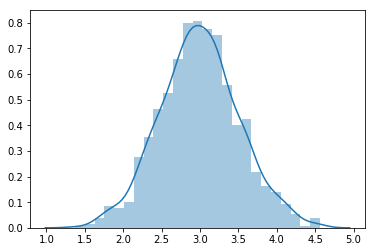

In [4]:
sns.distplot(data)

## Generator of normal PDF functions

/home/lukas/.pyenv/versions/3.6.3/envs/mcmc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


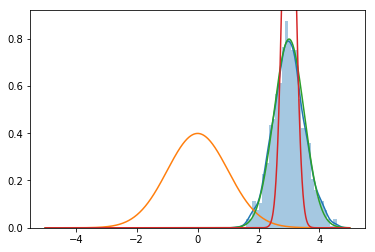

In [5]:
def get_norm_pdf(loc, scale):
    def pdf(x):
        return norm.pdf(x, loc=loc, scale=scale)
    return pdf

def plot_pdf(pdf, minx=-5, maxx=5):
    X = np.array([x/100 for x in range(minx*100, maxx*100)])
    Y = np.array([pdf(x) for x in X])
    plt.plot(X, Y)
    
sns.distplot(data, bins=30)
n1 = get_norm_pdf(0, 1)
n2 = get_norm_pdf(3, 0.5)
n3 = get_norm_pdf(3, 0.2)
plot_pdf(n1)
plot_pdf(n2)
plot_pdf(n3)


## likelihood

In [6]:
def likelihood(pdf, data):
    probabilities = [pdf(x) for x in data]
    return np.prod(probabilities)


def log_likelihood(pdf, data):
    probabilities = [pdf(x) for x in data]
    return np.sum(np.log(probabilities))

likelihood works for small data:

In [7]:
print(likelihood(n1, data[:10]))
print(likelihood(n2, data[:10]))
print(likelihood(n3, data[:10]))

3.2809791690635833e-21
0.00012770631133746568
6.185490078474104e-16


we will underflow for bigger data:

In [8]:
print(likelihood(n1, data[:1000]))
print(likelihood(n2, data[:1000]))
print(likelihood(n3, data[:1000]))


0.0
0.0
0.0


thats why we use log likelihood:

In [9]:
print(log_likelihood(n1, data[:1000]))
print(log_likelihood(n2, data[:1000]))
print(log_likelihood(n3, data[:1000]))


-5533.579480581344
-754.949508971195
-2616.739097810995


## Searches

helper function that will evaluate data likelihood for given normal dist params

In [10]:
def loglike_for_params(loc, scale, data=data):
    pdf = get_norm_pdf(loc, scale)
    return log_likelihood(pdf, data)

print(loglike_for_params(0, 1))
print(loglike_for_params(2.9, 0.4))
print(loglike_for_params(3, 0.5))



-5533.579480581344
-857.030630652093
-754.949508971195


### grid search

In [11]:
def grid_search(loc_range=(-2, 6), scale_range=(0.2, 2), steps=10):
    loc_min, loc_max = loc_range
    locs = np.linspace(loc_min, loc_max, steps)
    
    scale_min, scale_max = scale_range
    scales = np.linspace(scale_min, scale_max, steps)
    
    
    for loc in locs:
        for scale in scales:
            loglike = loglike_for_params(loc, scale)
            yield {
                'loc': loc, 
                'scale': scale, 
                'loglike': loglike,
            }
            
grid_df = pd.DataFrame(grid_search())[['loc', 'scale', 'loglike']]
grid_df.head(5)
            

,loc,scale,loglike
0,-2.0,0.2,-314381.381110
1,-2.0,0.4,-78770.617924
2,-2.0,0.6,-35416.099630
3,-2.0,0.8,-20387.787512
4,-2.0,1.0,-13521.813753


In [12]:
grid_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
62,3.333333,0.6,-935.351935
63,3.333333,0.8,-992.366934
64,3.333333,1.0,-1108.744582
53,2.444444,0.8,-1138.517277
61,3.333333,0.4,-1188.935609


In [13]:
grid_df.pivot('loc', 'scale', 'loglike')

scale,0.2,0.4,0.6000000000000001,0.8,1.0,1.2,1.4000000000000001,1.6,1.8,2.0
loc,,,,,,,,,,
-2.000000,-314381.381110,-78770.617924,-35416.099630,-20387.787512,-13521.813753,-9853.256770,-7685.449147,-6311.940295,-5396.501500,-4762.804519
-1.111111,-213277.543518,-53494.658526,-24182.339898,-14068.797663,-9477.660249,-7044.816837,-5622.105523,-4732.192833,-4148.305975,-3751.766143
-0.222222,-131926.792345,-33156.970732,-15143.367545,-8984.375715,-6223.630202,-4785.073749,-3961.886111,-3461.087346,-3143.975713,-2938.258631
0.666667,-70329.127592,-17757.554544,-8299.182573,-5134.521668,-3759.723612,-3074.027506,-2704.790912,-2498.623834,-2383.510716,-2322.281983
1.555556,-28484.549259,-7296.409961,-3649.784980,-2519.235522,-2085.940479,-1911.678108,-1850.819926,-1844.802297,-1866.910984,-1903.836200
2.444444,-6393.057346,-1773.536983,-1195.174768,-1138.517277,-1202.280802,-1298.025555,-1399.973152,-1499.622736,-1594.176516,-1682.921281
3.333333,-4054.651853,-1188.935609,-935.351935,-992.366934,-1108.744582,-1233.069846,-1352.250591,-1463.085150,-1565.307312,-1659.537226
4.222222,-21469.332779,-5542.605841,-2870.316483,-2080.784492,-1805.331820,-1716.810983,-1707.652242,-1735.189540,-1780.303373,-1833.684035
5.111111,-58637.100125,-14834.547677,-7000.068410,-4403.769951,-3292.042513,-2749.248965,-2466.178107,-2315.935905,-2239.164698,-2205.361709


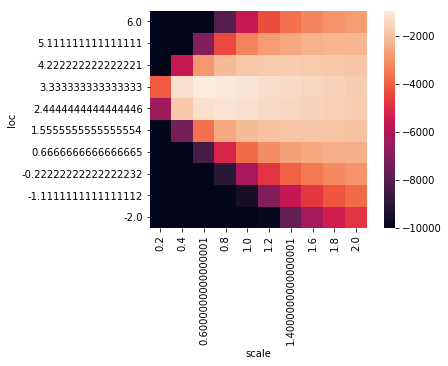

In [14]:
def plot_heatmap(df):
    ax = sns.heatmap(df.pivot('loc', 'scale', 'loglike'), vmin=-10000, square=True)
    ax.invert_yaxis()
plot_heatmap(grid_df)

### random search

In [15]:
def random_search(loc_range=(-2, 6), scale_range=(0.2, 2), samples=100):
    loc_min, loc_max = loc_range
    
    scale_min, scale_max = scale_range
    
    for _ in range(samples):
        loc = np.random.uniform(loc_min, loc_max)
        scale = np.random.uniform(scale_min, scale_max)
        loglike = loglike_for_params(loc, scale)
        yield {
            'loc': loc, 
            'scale': scale, 
            'loglike': loglike,
        }
            
loglikes_df = pd.DataFrame(random_search())[['loc', 'scale', 'loglike']]
loglikes_df.head(5)

,loc,scale,loglike
0,4.435491,1.905756,-1886.251472
1,1.809184,1.427844,-1684.330690
2,2.342509,0.409669,-2079.627542
3,1.619625,1.816498,-1842.211407
4,-0.875079,0.450297,-37689.346224


here we see that by using random instead of grid, we are already gaining little bit of better estimates:

In [16]:
loglikes_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
25,3.035164,0.489038,-760.220320
29,2.801442,0.559449,-820.059772
67,2.943658,0.774724,-886.192486
5,2.585660,0.719061,-1006.286977
86,2.659544,0.448000,-1053.884595


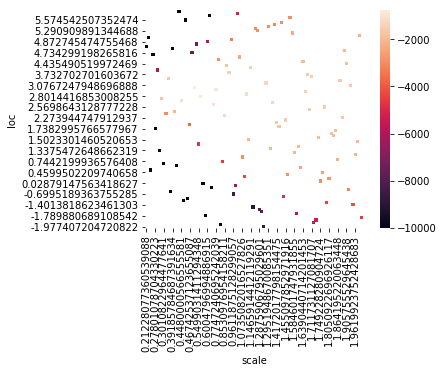

In [17]:
plot_heatmap(loglikes_df)

### random walk

In [18]:
def random_walk(loc_range=(-2, 6), scale_range=(0.2, 2), steps=100, extent_ratio=0.01):
    loc_min, loc_max = loc_range
    loc_step_extent = (loc_max - loc_min) * extent_ratio
    
    scale_min, scale_max = scale_range
    scale_step_extent = (scale_max - scale_min) * extent_ratio
    
    best_loc = np.random.uniform(loc_min, loc_max)
    best_scale = np.random.uniform(scale_min, scale_max)
    best_loglike = loglike_for_params(best_loc, best_scale)
    for _ in range(steps):
        
        new_loc = best_loc + np.random.normal(scale=loc_step_extent)
        new_scale = best_scale + np.random.normal(scale=scale_step_extent)
        new_loglike = loglike_for_params(new_loc, new_scale)
        if new_loglike > best_loglike:
            best_loglike = new_loglike
            best_loc = new_loc
            best_scale = new_scale
            
        yield {
            'loc': new_loc, 
            'scale': new_scale, 
            'loglike': new_loglike,
        }
        
loglikes_df = pd.DataFrame(random_walk())[['loc', 'scale', 'loglike']]
loglikes_df.head(5)

,loc,scale,loglike
0,3.641802,0.538863,-1478.510057
1,3.719932,0.520817,-1725.294241
2,3.669253,0.545269,-1523.879224
3,3.666028,0.540122,-1530.148350
4,3.719884,0.544828,-1644.506571


In [19]:
loglikes_df.sort_values(by='loglike', ascending=False).head(5)

,loc,scale,loglike
78,2.982903,0.508770,-754.427872
36,3.009979,0.517320,-754.568904
32,2.976438,0.515044,-754.656582
80,3.006080,0.523999,-754.668150
63,2.996781,0.527438,-754.700367


### plot the walk

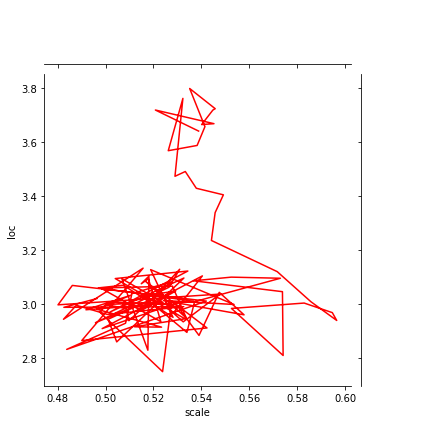

In [20]:
g = sns.JointGrid(x=loglikes_df['scale'], y=loglikes_df['loc'])
g.plot_joint(plt.plot, color="r")

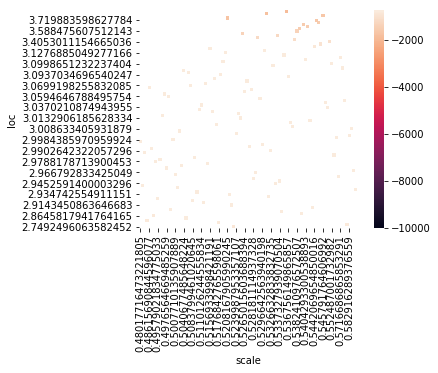

In [21]:
ax = plot_heatmap(loglikes_df)
